In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt

import random
import sys, os
import multiprocessing

In [2]:
# use gpu for training if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Specification

- Possible training techiniques to apply:
    - Dropout: prevent from overfitting 
    - Batch Normalization: accelerate the training of deep network and make the training robust to bad weights initializations

- Some useful resources for batch normalization and dropout
    - [notes from Standord CS231n](https://cs231n.github.io/neural-networks-2/#reg): definition about batch normalization and dropout
    - [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html): pytorch official document page
    - [batch normalization layer](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm1d): pytorch offical document page
    - [nn.Dropout v.s. F.dropout](https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout): nn.Dropout is generally preferred

Dropout:
![dropout](https://cs231n.github.io/assets/nn2/dropout.jpeg)

In [3]:
class Multiple_layer_fc_network(nn.Module):
    
    def __init__(self, input_size, num_classes, 
                 apply_dropout=False, dropout_p=0.50, apply_bn=False):
        super(Multiple_layer_fc_network, self).__init__()
        self.apply_dropout = apply_dropout
        self.apply_bn = apply_bn
        
        if self.apply_dropout:
            print(f"apply dropout with dropping rate {dropout_p}")
        if self.apply_bn:
            print(f"apply batch normalization")
        
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.bn2 = nn.BatchNorm1d(num_features=50)
        self.dropout = nn.Dropout(p=dropout_p) # prob that the element to be zeroed
    
    def forward(self, x):
        # hidden layer 1
        x = self.fc1(x)
        if self.apply_bn:
            x = self.bn1(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)      
        # hidden layer 2
        x = self.fc2(x)
        if self.apply_bn:
            x = self.bn2(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)   
        # output layer
        x = self.fc3(x)
        return x

### Dimensionality checking with random inputs
Recommend to do so to ensure the data flow in your model is as you expected

In [4]:
x = torch.randn(64, 784)
model = Multiple_layer_fc_network(input_size=784, num_classes=10)
out = model(x)
print(out.shape)

torch.Size([64, 10])


### Global Variables Specification
**[Important]** Configure this part to your preferred setting (especially the **path to the data** and the **path to save your trained model**) before you start training your model

In [5]:
# model training specifications
input_size = 784 # 28*28=784
num_classes = 10 # number of classes of labels
learning_rate = 0.001 # learning rate
batch_size = 64 # number of training samples for each mini batch
num_epochs = 50 # the maximum number of epochs for the model training
num_workers = 16 # multiprocessing.cpu_count() 
apply_dropout = False # whether to apply drop out
dropout_p = 0.20 # proportion of connections to be "turned off" between layers
apply_bn = True # whether to apply batch normalization
early_stopping_criteria= 5 # the tolerance level before terminating the training

val_proportion = 0.2 # the proportion of samples to be used as validation set

random_seed = 20220215 # random seed for reproducibility

data_dir = "/mnt/addtional_data_ssd/pytorch-tutorial-2022-spring/data" # change this path to your preferred directory to store fashion minst data
model_dir = "/mnt/addtional_data_ssd/pytorch-tutorial-2022-spring/model" 

saved_model_fn = os.path.join(model_dir, "best_fcn_model.pt")

### Set up Dataset and DataLoader

Dataset defines how we can access the data.  

We will use a pre-loaded benchmark dataset called [**FashionMNIST**](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) in this notebook. There are some pre-loaded datasets for other tasks, you can find them here: [Image datasets](https://pytorch.org/vision/stable/datasets.html), [Text datasets](https://pytorch.org/text/stable/datasets.html), and [Audio datasets](https://pytorch.org/audio/stable/datasets.html).

In [6]:
train_dataset = datasets.FashionMNIST(root=data_dir, 
                                      train=True, 
                                      transform=transforms.ToTensor(), 
                                      download=True)
test_dataset  = datasets.FashionMNIST(root=data_dir, 
                                      train=False, 
                                      transform=transforms.ToTensor(), 
                                      download=True)


val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

# further split the entire training set to the training and validation set
# validation set is for monitoring the training process
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, 
                                                           lengths=[train_size, val_size],
                                                           generator=torch.Generator().manual_seed(random_seed))

number samples in train: 48000
number samples in val: 12000
number samples in test: 10000


Print the labels of the first 10 samples in the training set.

Try to run the following block multiple times and the output should stay the same **since we have set the random seed **in the random_split() method.

In [7]:
t = [train_dataset[i][1] for i in range(10)]
print(t)

[8, 6, 9, 9, 6, 8, 1, 7, 9, 1]


DataLoader can help you load multiple samples in parallel

In [8]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=num_workers)

Check the dimensions (shapes) of the data

In [9]:
image, target = train_dataset[0]
print("input image has shape:")
print(image.shape)

input image has shape:
torch.Size([1, 28, 28])


### Show Images
Just to get a better sense of how fashion-mnist dataset looks like

In [10]:
def show_single_image(dataset, image_index):
    image, label = dataset[image_index]
    image = torch.squeeze(image).numpy()
    plt.imshow(image, cmap="binary")
    plt.show()

def show_imgs(n_rows, n_cols, dataset, class_names):
    assert n_rows * n_cols < len(dataset)
    selected_indicies = random.sample(range(len(dataset)), n_rows * n_cols)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)
            image_index = selected_indicies[index]
            image, label = dataset[image_index]
            image = torch.squeeze(image).numpy()
            plt.imshow(image, cmap="binary", interpolation = 'nearest')
            plt.axis('off')
            plt.title(class_names[label])
    plt.show()

show the first image


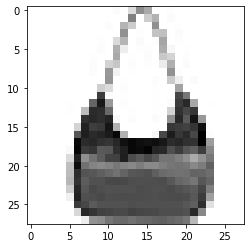

show 20 randomly selected images


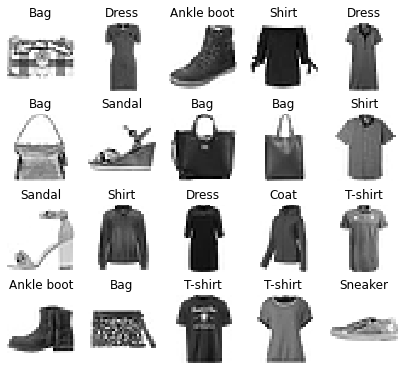

In [11]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("show the first image")
show_single_image(train_dataset, image_index=0)
print("show 20 randomly selected images")
show_imgs(4, 5, train_dataset, class_names)

### Model Initialization, Loss, Optimizer

Three key components that you need to instantiate before the model training:
1. The model
2. The loss function
3. The optimizer

[Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html): Useful when training a classification problem with C classes.

[Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html): an optimizer with adaptive learning rate. To check the exact math, see this [note](https://cs231n.github.io/neural-networks-3/) from CS 231n.

In [12]:
# instantiate the model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

apply batch normalization
Multiple_layer_fc_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Initialize a dictionary to record training progress
For plotting the learning curve

In [13]:
train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

### Train the model
- Loading the data
- Switch to training mode
- Training loop:
    - Forward pass: calculate predictions and loss
    - Backward pass: calculate gradients
    - Update weights (parameters) of the network: based on calculated gradients
- Switch to evaluation mode
- [Model saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- Early stopping to avoid overfitting
![](https://stanford.edu/~shervine/teaching/cs-230/illustrations/update-weights-en.png?5394a7bb976892418366d08646a0fd09)

In [14]:
best_val_loss = float('inf')
early_stopping_step = 0

# training loop
for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    # loop over batches
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to appropriate shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad() # clear the calculated gradients from the last batch
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1) #(64, 10)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx+1}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0 # reset running train loss every 200 steps
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        # load and reshape the data
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        
        # forward pass
        preds = clf(images)
        
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images) # shape: [batch, #classes]
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    
    # if achieving better validation loss
    # 1) reset the early stopping marker
    # 2) save the best trained model
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
        
    # if not for the current epoch
    # 3) update the early stopping marker and check whether we should stop training
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step == early_stopping_criteria):
            print("early stopping criteria satisfied")
            print(f"stop training at epoch {epoch}")
            break
    print("--------------------------------------------")
            

[epoch 0 step 200] running training loss: 0.776
[epoch 0 step 400] running training loss: 0.453
[epoch 0 step 600] running training loss: 0.420
[epoch 0] val loss: 0.389, accuracy: 85.342%
current best validation loss: 0.389
=====>save the best model
--------------------------------------------
[epoch 1 step 200] running training loss: 0.375
[epoch 1 step 400] running training loss: 0.350
[epoch 1 step 600] running training loss: 0.343
[epoch 1] val loss: 0.357, accuracy: 86.458%
current best validation loss: 0.357
=====>save the best model
--------------------------------------------
[epoch 2 step 200] running training loss: 0.311
[epoch 2 step 400] running training loss: 0.319
[epoch 2 step 600] running training loss: 0.313
[epoch 2] val loss: 0.320, accuracy: 88.300%
current best validation loss: 0.320
=====>save the best model
--------------------------------------------
[epoch 3 step 200] running training loss: 0.294
[epoch 3 step 400] running training loss: 0.289
[epoch 3 step 60

### Test the network on the testing set

Load the saved best model and evaluate the model with testing data.

In [15]:
# load the saved best model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")


apply batch normalization
testing loss: 0.336, testing accuracy: 88.410%


### Plot learning curve

In [16]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

    train_loss  train_acc  val_loss  val_acc
0        0.524      0.832     0.389    0.853
1        0.354      0.872     0.357    0.865
2        0.317      0.882     0.320    0.883
3        0.290      0.893     0.315    0.883
4        0.271      0.899     0.329    0.879
5        0.256      0.905     0.316    0.881
6        0.240      0.910     0.332    0.880
7        0.229      0.915     0.313    0.887
8        0.220      0.918     0.309    0.885
9        0.208      0.922     0.333    0.881
10       0.199      0.924     0.305    0.894
11       0.192      0.928     0.307    0.894
12       0.184      0.932     0.349    0.874
13       0.178      0.934     0.325    0.886
14       0.170      0.937     0.334    0.890
15       0.162      0.939     0.327    0.889


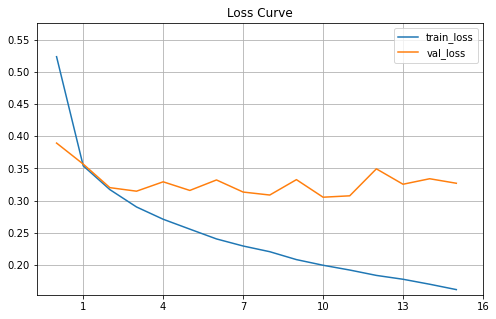

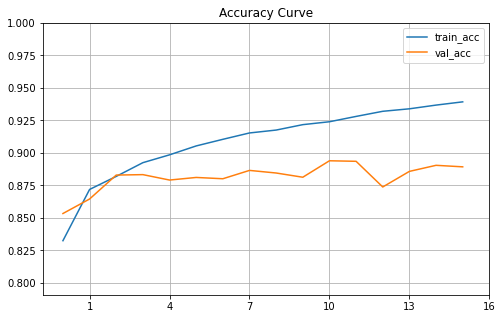

In [17]:
train_state_df = pd.DataFrame(train_state)
print(train_state_df.round(3))
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")